# MS-CELEB Face Recognition

## Importing the libraries


In [1]:
import os
import shutil
import pathlib
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import image_dataset_from_directory
from tensorflow import keras
from keras import layers
from PIL import Image
from mtcnn.mtcnn import MTCNN

# to make this notebook's output stable across runs
np.random.seed(42)

# Constants
SIZE_OF_IMAGES = (256, 256)
# SIZE_OF_IMAGES = (512, 512)
SIZE_OF_BATCH = 32
DATA_DIR = pathlib.Path('./data/14-celebrity-faces-dataset/data/')
MODELS_DIR = pathlib.Path('./models')

print(tf.config.list_physical_devices('GPU'))


2023-01-18 04:56:32.087678: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-18 04:56:35.807220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-18 04:56:35.986910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-18 04:56:35.987337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Downloading the data

In [ ]:
! kaggle datasets download -d danupnelson/14-celebrity-faces-dataset

## Functions

In [2]:

def plot_history(history):
    """"Plot the accuracy, loss, precision, recall and AUC \
        curves for training and validation."""

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    auc = history.history["auc"]
    val_auc = history.history["val_auc"]

    precision = history.history["precision"]
    val_precision = history.history["val_precision"]

    recall = history.history["recall"]
    val_recall = history.history["val_recall"]

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(321)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(322)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid()

    plt.subplot(323)
    plt.plot(epochs, precision, "bo", label="Training precision")
    plt.plot(epochs, val_precision, "b", label="Validation precision")
    plt.title("Training and validation precision")
    plt.legend()
    plt.grid()

    plt.subplot(324)
    plt.plot(epochs, recall, "bo", label="Training recall")
    plt.plot(epochs, val_recall, "b", label="Validation recall")
    plt.title("Training and validation recall")
    plt.legend()
    plt.grid()

    plt.subplot(3, 2, (5, 6))
    plt.plot(epochs, auc, "bo", label="Training AUC")
    plt.plot(epochs, val_auc, "b", label="Validation AUC")
    plt.title("Training and validation AUC")
    plt.legend()
    plt.grid()

    plt.show()

def show_eval_results(test_model, test_dataset, labels=None):
    """Evaluate the model on the test dataset and print the results."""

    eval_results = test_model.evaluate(test_dataset, labels)

    print(f"Test loss: {eval_results[0]:.3f}")
    print(f"Test accuracy: {eval_results[1]:.3f}")
    print(f"Test AUC: {eval_results[2]:.3f}")
    print(f"Test Precision: {eval_results[3]:.3f}")
    print(f"Test Recall: {eval_results[4]:.3f}")


detector = MTCNN()


def extract_face(filename, required_size=SIZE_OF_IMAGES):
    # # load image from file
    pixels = plt.imread(filename)

    if pixels.ndim == 2:
        pixels = np.stack((pixels,)*3, axis=-1)

    if pixels.shape[2] == 1:
        pixels = np.concatenate((pixels,)*3, axis=0)

    if pixels.shape[2] > 3:
        pixels = pixels[:, :, :3]
    # create the detector, using default weights
    # detect faces in the image
    results = detector.detect_faces(pixels)
    if len(results) == 0:
        return None
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array


2023-01-18 04:56:36.089779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 04:56:36.093044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-18 04:56:36.093349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-18 04:56:36.093643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may h

## Face detection

In [6]:
for folder in os.listdir(DATA_DIR / 'train'):
    for file in os.listdir(DATA_DIR / 'train' / folder):
        pixels = extract_face(DATA_DIR / 'train' / folder / file)
        if pixels is None:
            continue
        os.makedirs(DATA_DIR / 'train_cropped' / folder, exist_ok=True)
        plt.imsave(DATA_DIR / 'train_cropped' / folder / file, pixels)

1/1 [==============================] - 0s 17ms/step


In [9]:
for folder in os.listdir(DATA_DIR / 'val'):
    for file in os.listdir(DATA_DIR / 'val' / folder):
        pixels = extract_face(DATA_DIR / 'val' / folder / file)
        os.makedirs(DATA_DIR / 'val_cropped' / folder, exist_ok=True)
        plt.imsave(DATA_DIR / 'val_cropped' / folder / file, pixels)

1/1 [==============================] - 0s 14ms/step


## Importing the data

In [3]:

train_dataset = image_dataset_from_directory(DATA_DIR / "train_cropped",
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             seed=42)

validation_dataset = image_dataset_from_directory(DATA_DIR / "val_cropped",
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             seed=42)


# test_dataset = image_dataset_from_directory(DATAS_DIR / "Testing",
#                                          image_size=SIZE_OF_IMAGES,
#                                          batch_size=SIZE_OF_BATCH,
#                                          label_mode='categorical',
#                                              color_mode='grayscale')

Found 212 files belonging to 14 classes.
Found 70 files belonging to 14 classes.


In [4]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 256, 256, 3)
labels batch shape: (32, 14)


## Data augmentation

In [5]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(SIZE_OF_IMAGES[0], SIZE_OF_IMAGES[1]),
    layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ]
)

AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds, resize=False, shuffle=False, augment=False, batch=False):
    # Resize and rescale all datasets.
    if resize:
        ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                    num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets.
    if batch:
        ds = ds.batch(SIZE_OF_BATCH)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)


In [6]:
train_dataset = prepare(train_dataset, shuffle=True, augment=True, resize=True)
validation_dataset = prepare(validation_dataset, resize=True)

In [7]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 256, 256, 3)
labels batch shape: (32, 14)


## Implementing Modern DNN Architecture using Residual CNN

In [7]:
def conv_layer_with_batch_norm(x, filter_size, kernel_size=3):

    x = layers.SeparableConv2D(filters=filter_size,
                               kernel_size=kernel_size,
                               use_bias=False,
                               padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


inputs = keras.Input(shape=SIZE_OF_IMAGES + (3,))

x = layers.Conv2D(filters=32, kernel_size=3,
                  use_bias=False, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = conv_layer_with_batch_norm(x, 32, kernel_size=3)

residual = x
x = conv_layer_with_batch_norm(x, 32, kernel_size=3)
x = conv_layer_with_batch_norm(x, 32, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(32, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(x, 32, kernel_size=3)
x = conv_layer_with_batch_norm(x, 32, kernel_size=3)
x = conv_layer_with_batch_norm(x, 64, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(64, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])


x = conv_layer_with_batch_norm(x, 64, kernel_size=3)

residual = x
x = conv_layer_with_batch_norm(x, 64, kernel_size=3)
x = conv_layer_with_batch_norm(x, 64, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(64, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(x, 128, kernel_size=3)
x = conv_layer_with_batch_norm(x, 128, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(128, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(x, 128, kernel_size=3)
x = conv_layer_with_batch_norm(x, 256, kernel_size=3)
x = conv_layer_with_batch_norm(x, 256, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(256, 1, strides=(2, 2), use_bias=False)(residual)
x = layers.Add()([residual, x])

x = layers.Dropout(0.2)(x)

residual = x
x = conv_layer_with_batch_norm(x, 512, kernel_size=3)
x = conv_layer_with_batch_norm(x, 512, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(512, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])


x = conv_layer_with_batch_norm(x, 512, kernel_size=3)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(14, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)


print(model.summary())


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 256, 256, 32  2400        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d_12[0][0]']              
 alization)                     )                                                           

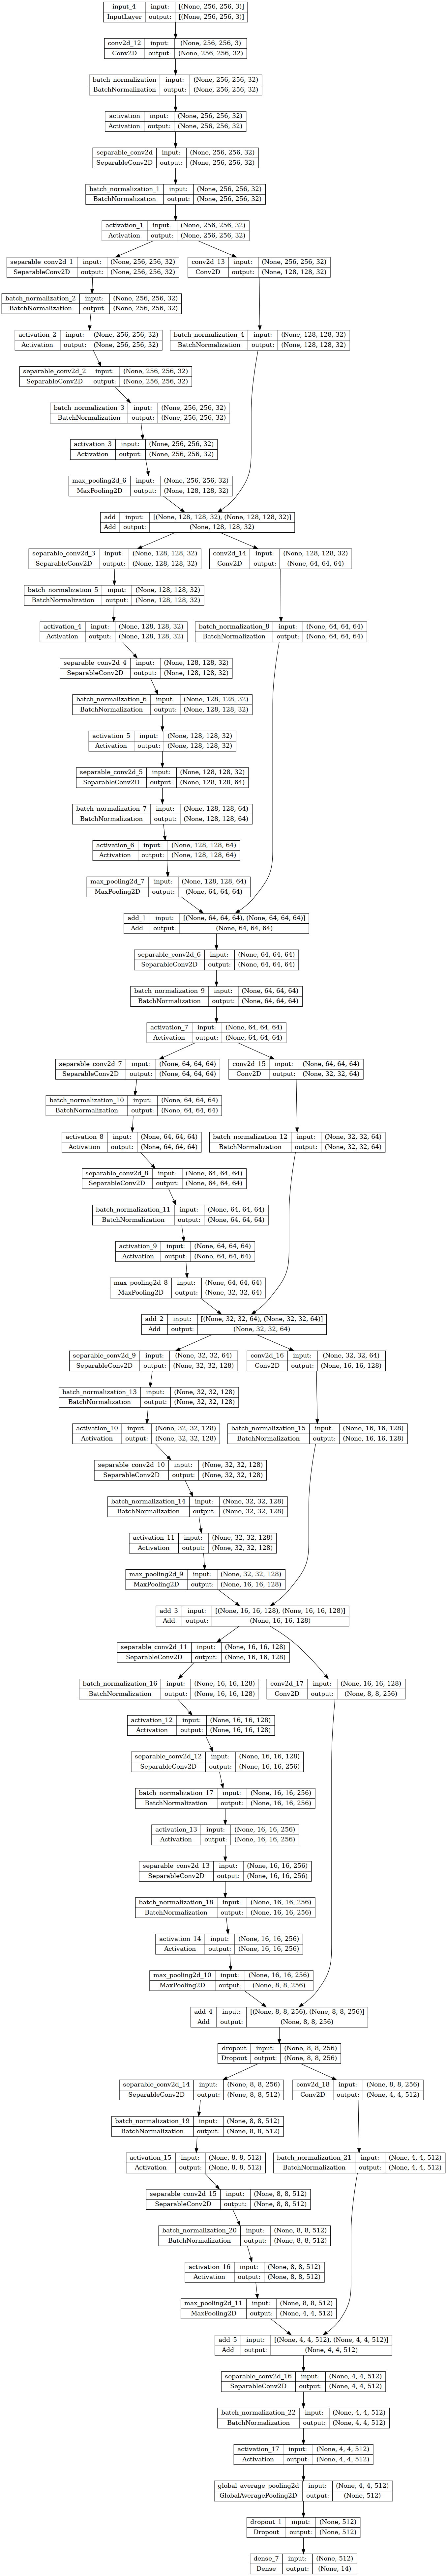

In [9]:
keras.utils.plot_model(model,
                       show_shapes=True,
                       show_layer_names=True,
                       to_file='./pngs/model.png')


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'modern_arch_ERS_042918012023.keras'),
                                    save_best_only=True,
                                    monitor="val_loss")
]
history = model.fit(train_dataset,
                    epochs=200,
                    validation_data=validation_dataset,
                    callbacks=callbacks)


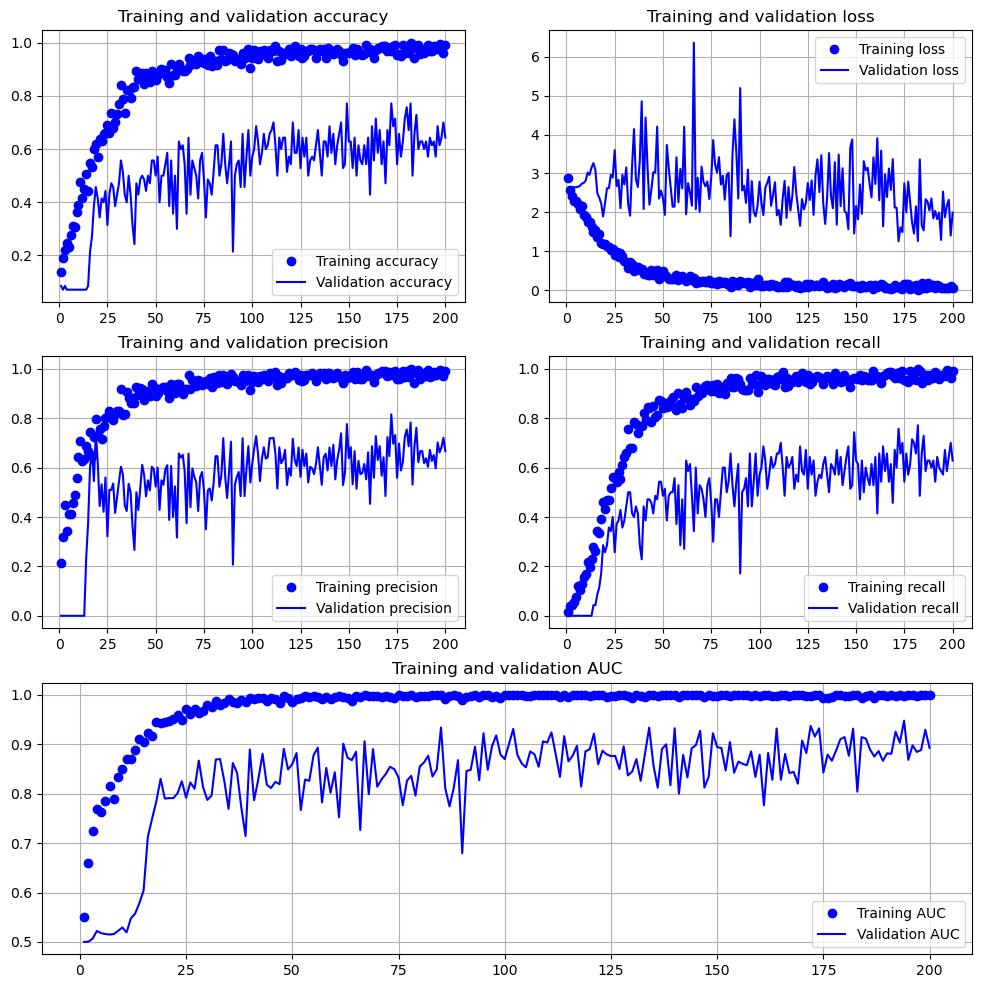

In [48]:
plot_history(history)


In [51]:

test_model = keras.models.load_model(
    os.path.join(MODELS_DIR, 'modern_arch_ERS_030618012023.keras'))
show_eval_results(test_model, validation_dataset)

9/9 [==============================] - 1s 29ms/step - loss: 1.2984 - accuracy: 0.7429 - auc: 0.9201 - precision: 0.7761 - recall: 0.7429
Test loss: 1.298
Test accuracy: 0.743
Test AUC: 0.920
Test Precision: 0.776
Test Recall: 0.743


In [56]:
train_dataset = prepare(train_dataset, shuffle=True, augment=True)